# Machine learning Project 1 : Higgs Boson

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go

%load_ext autoreload
%autoreload 2

In [3]:
from proj1_helpers import *
from implementations import *

data_path = "datasets/train.csv"
yb, input_data, ids = load_csv_data(data_path, sub_sample=True)

### Clean data 
We set to 0 the invalid values and standardize the data by columns in order to deal with dimensionless variables that span more or less the same range

In [4]:
cleansubx = input_data
cleansubx[np.where(cleansubx == -999)] = 0
means_by_columns = np.mean(cleansubx, axis=0)

for i in range(30):
    input_data[:,np.where(input_data[:,i]==-999)] = means_by_columns[i]
    
input_data = standardize(input_data)
rows, cols = input_data.shape[0], input_data.shape[1]

KeyboardInterrupt: 

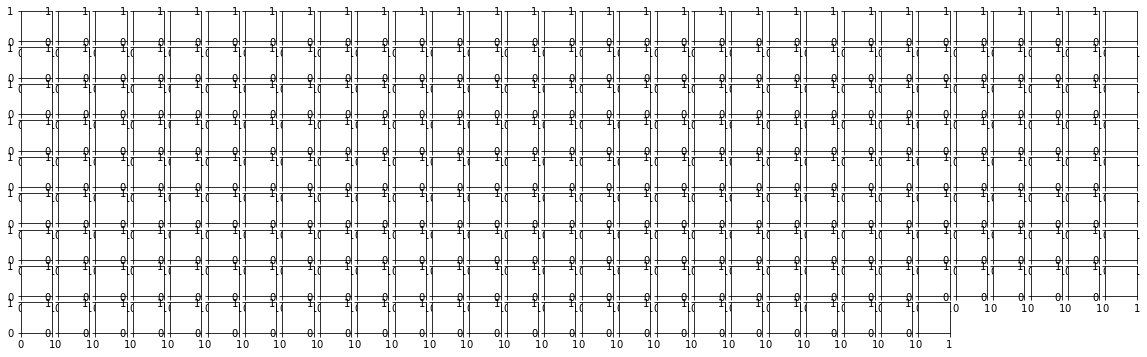

In [39]:
# Plot of the y variables against each of the features

fig0, axs = plt.subplots(30,30, figsize=(20,20))

for i in range(30):
    for j in range(i+1,30):
        axs[i,j].scatter(input_data[:,i], input_data[:,j])
        axs[i,j].set_ylabel('Prediction')
        axs[i,j].set_xlabel('Column %i' % i)
    

Correlation coefficients of the features, to understand if they are linearly correlated

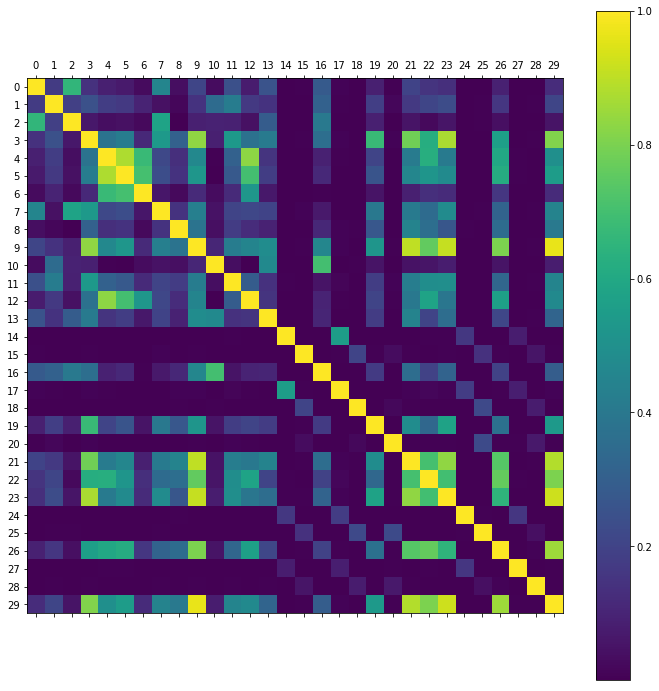

In [4]:
cor_matrix = np.corrcoef(input_data.T)

plt.figure(1, figsize=(12,12))
plt.matshow(np.abs(cor_matrix),1)
plt.xticks(range(cols), range(cols))
plt.yticks(range(cols), range(cols))
plt.colorbar()
plt.savefig('correlation_matrix'+'.png')

We decide to leave out columns 5, 9, 12, 21, 22, 23, 29 due to the high correlation with the others.

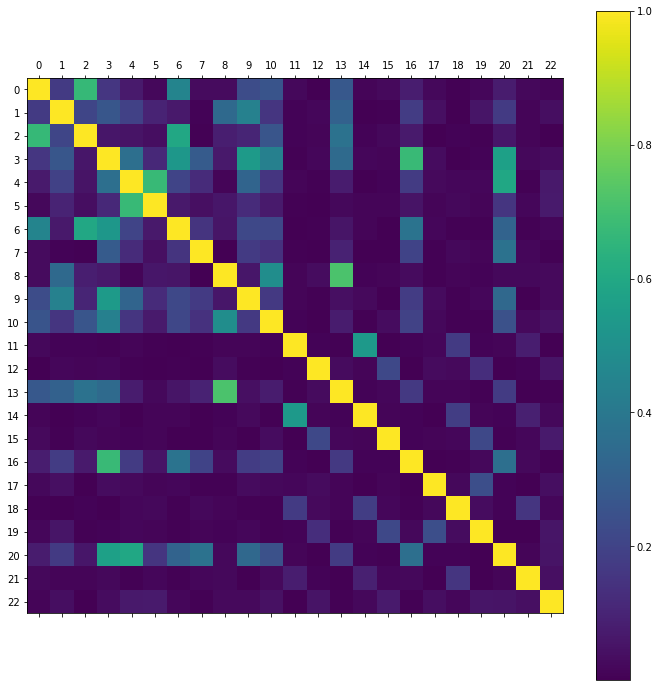

In [5]:
data = np.delete(input_data,[5,9,12,21,22,23,29],1)

#Compute again the correlation and check
cor_matrix = np.corrcoef(data.T)
plt.figure(2, figsize=(12,12))
plt.matshow(np.abs(cor_matrix),2)
plt.xticks(range(23), range(23))
plt.yticks(range(23), range(23))
plt.colorbar()
plt.savefig('correlation_new'+'.png')

# Fitting a linear model
First of all we fit our linear model on the subset of data, and then use the whole train dataset to test it, at least at the beginning. In the end we will use the whole dataset to train the model. We try with 5 polynomial degrees per feature, otherwise the number of features becomes too large.
Compare the mse and the computational time of the 3 methods to get the least squares solution: the first one is the correct one, but maybe the others are faster.


1.Linear regression with mse and normal equations


2.Linear regression with mse and gradient descent


3.Linear regression with mse and stochastic gradient descent



In [6]:
# Function that builds a polynomial basis of the chosen degree for a column 
def build_poly_col(x, degree):
    """polynomial basis functions for input column x, for j=1 up to j=degree."""
    
    y = x
        
    for n in range(2,degree+1):
        x = np.c_[x, np.power(y,n)]
            
    return x

# Function that builds a polynomial basis for the data (each column has the same degree)
def build_poly(data, degree):
    """polynomial basis for input data up to the chosen degree in each column"""
    
    X = np.c_[np.ones(data.shape[0])]
    for j in range(data.shape[1]):
        x_col = build_poly_col(data[:,j], degree)
        X = np.c_[X, x_col]
        
    return X


In [7]:
# Functions to build the indices and split the data to perform cross validation

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def split_dataset(y, x, k, k_indices):
    """Returns the matrices and vectors Test and Train used in a k-fold cross validation"""
    
    # get k'th subgroup in test, others in train.
    X_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    X_train = np.delete(x,k_indices[k],0)
    y_train = np.delete(y,k_indices[k])
    
    return X_test, y_test, X_train, y_train


In [ ]:

def ls_polynomial_basis(yb, data, kfolds, degrees):
    """Builds a polynomial basis according to the chosen degree and solves the least squares problem
        with the normal equations, performing a k-fold cross validation to compute the rmse and the weights"""
    
    rmse_train=[]
    rmse_test=[]
    seed = 2

    # Build indices to split data
    k_indices = build_k_indices(yb, kfolds, seed)

    # Define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []
    w_ls = []

    # Choose the degrees and loop over them
    for degree in degrees:
        rmse_tr_k=[]
        rmse_te_k=[]
        w_ls_deg = []
    
        # Build X matrix
        data1 = build_poly(data, degree)
    
        # Loop over the folds
        for k in range(kfolds):
        
            data_test_ls, y_test_ls, data_train_ls, y_train_ls = split_dataset(yb, data1, k, k_indices)   
        
            # Train and store rmse
            w_ls_k, mse_ls_k = least_squares(y_train_ls, data_train_ls)
            rmse_test = np.sqrt(2*compute_mse(y_test_ls, data_test_ls, w_ls_k))
            
            rmse_tr_k.append(np.sqrt(2*mse_ls_k))
            rmse_te_k.append(rmse_test)
            w_ls_deg.append(w_ls_k)
            
        
        # Append rmse (and std over the folds) in the vectors
        rmse_tr.append(np.mean(rmse_tr_k))
        rmse_te.append(np.mean(rmse_te_k))
        std_tr.append(np.std(rmse_tr_k))
        std_te.append(np.std(rmse_te_k))
        w_ls.append(np.mean(w_ls_deg, axis=0))
        

    return rmse_tr, rmse_te, std_tr, std_te, w_ls

We try this first simple model both on the matrix with all the features and on the reduced matrix, and compare the results.

In [ ]:
degrees = range(1,5)

rmse_train_tot, rmse_test_tot, std_train_tot, std_test_tot, w_tot = ls_polynomial_basis(yb, input_data, 5, degrees)
rmse_train_red, rmse_test_red, std_train_red, std_test_red, w_red = ls_polynomial_basis(yb, data, 5, degrees)

# Plot RMSE to compare the results
fig3, axs= plt.subplots(1,2, figsize=(14,6))
axs[0].plot(degrees, rmse_train_tot, marker=".", c='b', label='Train error')
axs[0].plot(degrees, rmse_test_tot, marker=".", c='r', label='Test error')
#plt.errorbar(degrees, rmse_tr, std_tr, marker=".", color='b', label='Train error')
#plt.errorbar(degrees, rmse_te, std_te, marker=".", color='r', label='Test error')
axs[0].set_xlabel("Degrees")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE Least Squares polynomial basis TOTAL")
axs[0].legend(loc=2)
axs[0].set_xticks(degrees)

axs[1].plot(degrees, rmse_train_red, marker=".", c='b', label='Train error')
axs[1].plot(degrees, rmse_test_red, marker=".", c='r', label='Test error')
axs[1].set_xlabel("Degrees")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE Least Squares polynomial basis REDUCED")
axs[1].legend(loc=2)
axs[1].set_xticks(degrees)
plt.savefig("rmse_ls")


In [ ]:
print('Training RMSE LS with NORMAL EQUATIONS: {err1}'.format(err1=rmse_train_red))

In both cases we find a significant overfitting even at a low degree (3,4) and to try to reduce it we use ridge regression. Before doing that, we try to minimize the mse loss function with GD and SGD: we should get an approximation of the minimum (compare the values with the exact value give by LS!) but maybe save computational time. However we should put a lot of effort in tuning the parameters for the iterative method (max_iter, gamma) and maybe it's not worth it.

### Gradient descent and stochastic gradient descent.

In [ ]:
degree = 2
max_iters = 2000

# build the matrix and call the methods, after setting the parameters to ensure convergence
data2 = build_poly(data,2)
w_initial_red = np.zeros(data2.shape[1])

w_red_GD, mse_red_GD = least_squares_GD(yb, data2, w_initial_red, max_iters, 0.001, tol=1e-4)
w_red_SGD, mse_red_SGD = least_squares_SGD(yb, data2, w_initial_red, max_iters, 0.001, tol=1e-5)

rmse_train_red_GD = np.sqrt(2*mse_red_GD)
rmse_train_red_SGD = np.sqrt(2*mse_red_SGD)

print('Training RMSE LS with NORMAL EQUATIONS: {err1}'.format(err1=rmse_train_red[1]))
print('Training RMSE LS with GRADIENT DESCENT: {err2}'.format(err2=rmse_train_red_GD))
print('Training RMSE LS with STOCHASTIC GRADIENT DESCENT: {err3}'.format(err3=rmse_train_red_SGD))

In [ ]:
print('Distance between the weigths normal equations/GD: {dist1}'.format(dist1=np.linalg.norm(w_red[1] - w_red_GD)))
print('Distance between the weigths normal equations/SGD: {dist2}'.format(dist2=np.linalg.norm(w_red[1] - w_red_SGD)))

We can't see any useful improvement by using the approximate methods to solve the minimization problem: the error on the training set is higher (correct) even if the one with GD is comparable, the computational time is even higher and moreover we need to run different attempts in order to decide the suitable parameters max_iters and gamma to obtain convergence. 

### Ridge regression.
Since we had the problem of overfitting, we try to introduce a regularization technique, based again on the mse loss function.
We try with different lambdas and do a 5 folds cross validation with a fixed degree (=2), then we try again changing the degree because this is exactly the purpose of the regularization technique.

In [41]:
def compute_accuracy(ypred, yknown):
    """Computes the accuracy of the prediction as n_exact_predictions/total"""
    
    nexact = np.sum(ypred == yknown)
    return nexact/len(yknown)

In [45]:
def ridge_lambda(yb, data, kfolds, degree, lambdas):
    """Builds a polynomial basis according to the chosen degree and solves the ridge regression
        with the normal equations for all the lambdas in lambdas, performing a k-fold cross validation 
        to compute the rmse and the weights"""
    
    rmse_train=[]
    rmse_test=[]
    seed = 3

    # Build indices to split data
    k_indices = build_k_indices(yb, kfolds, seed)

    # Define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    std_tr = []
    std_te = []
    w_ridge = []
    accuracy = []

    # Loop over the lambdas
    for lam in lambdas:
        rmse_tr_k=[]
        rmse_te_k=[]
        w_ridge_lam = []
        accuracy_lam = []
        
        # Build X matrix
        data1 = build_poly(data, degree)
    
        # Loop over the folds
        for k in range(kfolds):
        
            data_test, y_test, data_train, y_train = split_dataset(yb, data1, k, k_indices)   
        
            # Train the model
            w_k, mse_k = ridge_regression(y_train, data_train, lam)
            rmse_test = np.sqrt(2*compute_mse(y_test, data_test, w_k))
            
            # Do the prediction on the test set and compute accuracy
            ypred = predict_labels(w_k, data_test)
            acc_k = compute_accuracy(ypred, y_test)
            
            # Store rmse, weights and accuracy
            rmse_tr_k.append(np.sqrt(2*mse_k))
            rmse_te_k.append(rmse_test)
            w_ridge_lam.append(w_k)
            accuracy_lam.append(acc_k)
        
        # Append rmse (and std over the folds) in the lists
        rmse_tr.append(np.mean(rmse_tr_k))
        rmse_te.append(np.mean(rmse_te_k))
        std_tr.append(np.std(rmse_tr_k))
        std_te.append(np.std(rmse_te_k))
        w_ridge.append(np.mean(w_ridge_lam, axis=0))
        accuracy.append(np.mean(accuracy_lam))
        

    return rmse_tr, rmse_te, std_tr, std_te, w_ridge, accuracy

In [46]:
def ridge_lambda_vis(lambdas, rmse_tr, rmse_te, std_train, std_test, acc, deg):
    """visualization of the curves of rmse_tr and rmse_te, and of the accuracy"""
    
    plt.figure(4, figsize=(16,5))
    plt.subplot(1,2,1)
    plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='Train error')
    plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='Test error')
    #plt.errorbar(np.log10(lambdas), rmse_tr, std_train, label='Train error')
    #plt.errorbar(np.log10(lambdas), rmse_te, std_test, label='Test error')
    #plt.plot(lambdas, rmse_tr, marker=".", color='b', label='Train error')
    #plt.plot(lambdas, rmse_te, marker=".", color='r', label='Test error')
    plt.xlabel("Lambda")
    plt.ylabel("RMSE")
    plt.title("RMSE ridge regression with degree {ddd}".format(ddd=deg))
    plt.legend(loc=2)
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.semilogx(lambdas, acc,  marker=".", color='b', label='Accuracy')
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title("ACCURACY ridge regression with degree {ddd}".format(ddd=deg))
    plt.legend(loc=1)
    plt.grid(True)

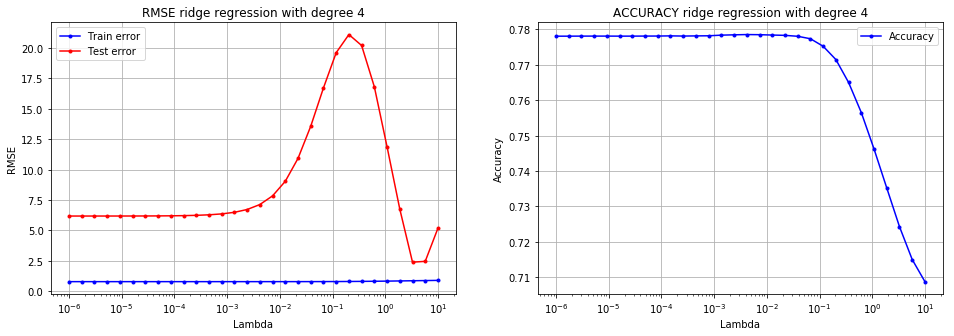

In [28]:
degree = 4
kfolds = 5
lambdas = np.logspace(-6,1,30)

rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, accuracy = ridge_lambda(yb, data, kfolds, degree, lambdas)
ridge_lambda_vis(lambdas, rmse_ridge_train, rmse_ridge_test, std_train, std_test, accuracy, degree)

### Grid search.
To find the best couple (lambda, degree): I run it on a subset of the data (to save computational time) and then on the whole matrix, and check the difference in the rmse test.

1.Define ranges for lambda and degree.

2.Loop over the degrees.

3.Call the function ridge_lambda(). 

4.Save rmse test in a matrix: rows=degree, cols=lambdas.

5.Get the minimum and the associated parameters.

In [47]:
# load a subset of the engineered data to save computational time
yb_grid = yb[::25]
data_grid = data[::25]
ids_grid= ids[::25]

In [49]:
# Define the range for the parameters 
degree_grid = range(1,15)
lambdas_grid = np.linspace(0,1,50)
kfolds = 5

losses = np.zeros((len(degree_grid),len(lambdas_grid)))
accuracies = np.zeros((len(degree_grid),len(lambdas_grid)))

# Perform a grid search
for i, deg in enumerate(degree_grid):
        
        rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, acc = ridge_lambda(yb_grid, data_grid, kfolds, deg, lambdas_grid)
        losses[i,:] = rmse_ridge_test
        accuracies[i,:] = acc
        
min_rmse_test, deg_opt_err, lam_opt_err = get_best_rmse(lambdas_grid, degree_grid, losses)  
max_accuracy, deg_opt_acc, lam_opt_acc = get_best_accuracy(lambdas_grid, degree_grid, accuracies)

print('Minimum Test RMSE (on the subset): {rmse}'.format(rmse=min_rmse_test))
print('Optimal degree: {d}'.format(d=deg_opt_err))
print('Optimal lambda: {l}'.format(l=lam_opt_err))

print('Maximum accuracy (on the subset): {acc}'.format(acc=max_accuracy))
print('Optimal degree: {d}'.format(d=deg_opt_acc))
print('Optimal lambda: {l}'.format(l=lam_opt_acc))

Minimum Test RMSE (on the subset): 0.8020850320897746
Optimal degree: 2
Optimal lambda: 0.0
Maximum accuracy (on the subset): 0.8137000000000001
Optimal degree: 12
Optimal lambda: 0.0


In [ ]:
def get_worst_parameters(lam, deg, losses):
    """Get the best (lam, deg) from the result of grid search."""
 
    max_row, max_col = np.unravel_index(np.argmax(losses), losses.shape)
    return losses[max_row, max_col], deg[max_row], lam[max_col]

max_rmse, deg_wor, lam_wor = get_worst_parameters(lambdas_grid, degree_grid, losses)
print('Maximum Test RMSE (on the subset): {rmse}'.format(rmse=max_rmse))
print('Worst degree: {d}'.format(d=deg_wor))
print('Worst lambda: {l}'.format(l=lam_wor))

Now we try again with another subset of data and see the differences in the rmse.

In [53]:
# load another subset of the engineered data to save computational time
yb_grid1 = yb[::10]
data_grid1 = data[::10]
ids_grid1 = ids[::10]

# Define the range for the parameters 
degree_grid = range(1,10)
lambdas_grid = np.linspace(-1,2,40)
kfolds = 5

losses = np.zeros((len(degree_grid),len(lambdas_grid)))
accuracies = np.zeros((len(degree_grid),len(lambdas_grid)))

# Perform a grid search
for i, deg in enumerate(degree_grid):
        
        rmse_ridge_train, rmse_ridge_test, std_train, std_test, w_ridge, acc = ridge_lambda(yb_grid1, data_grid1, kfolds, deg, lambdas_grid)
        losses[i,:] = rmse_ridge_test
        accuracies[i,:] = acc
        
min_rmse_test1, deg_opt1, lam_opt1 = get_best_rmse(lambdas_grid, degree_grid, losses)   
max_accuracy1, deg_opt_acc1, lam_opt_acc1 = get_best_accuracy(lambdas_grid, degree_grid, accuracies)

print('Minimum Test RMSE (on the second subset): {rmse}'.format(rmse=min_rmse_test1))
print('Optimal degree: {d}'.format(d=deg_opt1))
print('Optimal lambda: {l}'.format(l=lam_opt1))

print('Maximum accuracy (on the second subset): {acc}'.format(acc=max_accuracy1))
print('Optimal degree: {d}'.format(d=deg_opt_acc1))
print('Optimal lambda: {l}'.format(l=lam_opt_acc1))

Minimum Test RMSE (on the second subset): 0.7987709164142258
Optimal degree: 3
Optimal lambda: 0.0
Maximum accuracy (on the second subset): 0.81068
Optimal degree: 9
Optimal lambda: 0.0


... I tried different dimensions of the subset (to get the best parameters) and even the total dataset, since the computational time wasn't too high. In the end I decided to keep the optimal values obtained with the whole dataset and perform another cross validation (same seed and kfolds) in order to get the best weights and used them in the prediction. If I use different seeds and kfolds I get different values for the error at each try, so I decided to keep the same, in order to doublecheck the results.

In [54]:
kfolds = 6

rmse_train=[]
rmse_test=[]
seed = 2

# Build indices to split data
k_indices = build_k_indices(yb, kfolds, seed)

# Define lists to store the loss of training data and test data
rmse_opt_tr = []
rmse_opt_te = []
w_opt_ridge_list = []
acc_opt = []

# Build X matrix
data1 = build_poly(data, deg_opt_acc1)

# Loop over the folds
for k in range(kfolds):
    
    data_test, y_test, data_train, y_train = split_dataset(yb, data1, k, k_indices)   
        
    # Train the model
    w_k, mse_k = ridge_regression(y_train, data_train, lam_opt_acc1)
    rmse_test = np.sqrt(2*compute_mse(y_test, data_test, w_k))
    
    # Do the prediction on the test set and compute accuracy
    ypred = predict_labels(w_k, data_test)
    acc_k = compute_accuracy(ypred, y_test)
            
    # Store rmse and weights
    rmse_opt_tr.append(np.sqrt(2*mse_k))
    rmse_opt_te.append(rmse_test)
    w_opt_ridge_list.append(w_k)
    acc_opt.append(acc_k)
    
# Get the best weights and the errors
w_opt_ridge = np.mean(w_opt_ridge_list, axis=0)

print('Test RMSE: {te}'.format(te=np.mean(rmse_opt_te)))
print('Train RMSE: {tr}'.format(tr=np.mean(rmse_opt_tr)))
print('Accuracy: {acc}'.format(acc=np.mean(acc_opt)))

6
Test RMSE: 34131199.85941365
Train RMSE: 0.7620564160998674
Accuracy: 0.8066249059984959


RMSE values with deg=2 and lambda=0.0011937766417144358, subset 1:25 :
Train RMSE: 0.8014915854773715
Test RMSE: 0.8305541106371641

RMSE values with deg=3 and lambda=0.007038135554931562, subset 1:20 :
Train RMSE: 0.793285618340946
Test RMSE: 1.3284903246013344

RMSE values with deg=2 and lambda=0.0002894266124716752, subset 1:15 :
Train RMSE: 0.801442221422809
Test RMSE: 0.8276588788503378

RMSE values with deg=4 and lambda=0.08376776400682924, subset 1:10 :
Train RMSE: 0.7945378819037896
Test RMSE: 17.95365044601708

RMSE values with deg=3 and lambda=0.11689518164985777, whole dataset:
Train RMSE: 0.8013123911573933
Test RMSE: 0.8075341744448667

In [55]:
# Let's try a submission!!! %---the last one was with the accuracy---%
data_path_sub = "datasets/test.csv"
yb_sub, input_data_sub, ids_sub = load_csv_data(data_path_sub, sub_sample=False)

#preparing the matrix
cleansubx = input_data_sub
cleansubx[np.where(cleansubx == -999)] = 0
means_by_columns = np.mean(cleansubx, axis=0)

for i in range(30):
    input_data_sub[:,np.where(input_data_sub[:,i]==-999)] = means_by_columns[i]
    
input_data_sub = standardize(input_data_sub)
data_sub = np.delete(input_data_sub,[5,9,12,21,22,23,29],1)

data_sub1 = build_poly(data_sub, deg_opt_acc1)
print(data_sub1.shape)


(568238, 208)


In [56]:
print(w_opt_ridge.shape)
ypred = predict_labels(w_opt_ridge, data_sub1)
create_csv_submission(ids_sub,ypred,'ridgeaccuracy.csv')

(208,)


## Logistic regression

In [31]:
dataprova = data[::10]
ybprova = yb[::10]
ids = ids[::10]

maxit = 10000
initial_w = np.zeros(data.shape[1])
gamma = 0.0001

w, loss = logistic_regression(ybprova, dataprova, initial_w, maxit, gamma)

Current iteration=50, loss=88.03719311083648, shape_w=(23,), shape_grad=(23,)
Current iteration=100, loss=-1.69894453644838, shape_w=(23,), shape_grad=(23,)
Current iteration=150, loss=-63.55213037600356, shape_w=(23,), shape_grad=(23,)
Current iteration=200, loss=-114.00903623811746, shape_w=(23,), shape_grad=(23,)
Current iteration=250, loss=-158.24947263082584, shape_w=(23,), shape_grad=(23,)
Current iteration=300, loss=-198.5982176998766, shape_w=(23,), shape_grad=(23,)
Current iteration=350, loss=-236.30555224377895, shape_w=(23,), shape_grad=(23,)
Current iteration=400, loss=-272.12072430339913, shape_w=(23,), shape_grad=(23,)
Current iteration=450, loss=-306.5263270396049, shape_w=(23,), shape_grad=(23,)
Current iteration=500, loss=-339.8498058729581, shape_w=(23,), shape_grad=(23,)
Current iteration=550, loss=-372.3223283916459, shape_w=(23,), shape_grad=(23,)
Current iteration=600, loss=-404.1123068911845, shape_w=(23,), shape_grad=(23,)
Current iteration=650, loss=-435.345623

Current iteration=5100, loss=-2897.385275402912, shape_w=(23,), shape_grad=(23,)
Current iteration=5150, loss=-2924.467680229138, shape_w=(23,), shape_grad=(23,)
Current iteration=5200, loss=-2951.547941076973, shape_w=(23,), shape_grad=(23,)
Current iteration=5250, loss=-2978.6261247250404, shape_w=(23,), shape_grad=(23,)
Current iteration=5300, loss=-3005.70229550178, shape_w=(23,), shape_grad=(23,)
Current iteration=5350, loss=-3032.7765153880173, shape_w=(23,), shape_grad=(23,)
Current iteration=5400, loss=-3059.848844114691, shape_w=(23,), shape_grad=(23,)
Current iteration=5450, loss=-3086.9193392559555, shape_w=(23,), shape_grad=(23,)
Current iteration=5500, loss=-3113.988056317852, shape_w=(23,), shape_grad=(23,)
Current iteration=5550, loss=-3141.0550488229037, shape_w=(23,), shape_grad=(23,)
Current iteration=5600, loss=-3168.120368390746, shape_w=(23,), shape_grad=(23,)
Current iteration=5650, loss=-3195.184064815061, shape_w=(23,), shape_grad=(23,)
Current iteration=5700, l